In [1]:
# # Imports

# Data Analysis
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Introduction

## Goal

This notebook aims to explore the application of Machine Learning in geotechnical engineering, specifically in the context of predicting soil classification based on Cone Penetration Test (CPT) results.
In this study, we will focus on predicting the soil classification of CPT tests using a supervised learning approach. 

🔷 The training set consists of 4 CPT tests that were performed next to sampling boreholes, allowing us to know the real soil classification for each test.

🔷 The test set consists of 2 CPT tests. Like the training set, the soil classification for these tests is known. However, unlike the training set, we will not use this information to train our machine learning models. Therefore, the two additional CPT tests serve as a way to measure the performance of our models and ensure that they are able to accurately predict the soil classification of new CPT tests.

## The data

The data used is taken from the geotechnical investigations of the Borssele Wind Farm in the Netherlands.\
All deliverables of studies that were used in this notebook are provided by the Netherlands Government under the **CC BY-SA 4.0 License**.
The data can be found on the following page: \
https://offshorewind.rvo.nl/cms/view/398f49f5-5dad-4ae1-b97b-14703e7b73b7/studies-borssele-i-ii

# The dataset

In [2]:
# Loading data
df = pd.read_csv('../data/global_df_CPT.csv')
df.head()

,id,z_(m),qc_(MPa),fs_(MPa),pwp2_(MPa),qt_(MPa),qnet_(MPa),Qt_(-),Fr_(%),Bq_(-),Ground_model
0,CPT_WFS1_1,0.16,0.774,0.004908,0.0018,0.775,0.772,482.500000,0.718,0.000259,A
1,CPT_WFS1_1,0.18,1.004,0.005917,0.0015,1.005,1.001,556.111111,0.660,-0.000300,A
2,CPT_WFS1_1,0.20,1.185,0.006696,0.0019,1.186,1.182,591.000000,0.599,-0.000085,A
3,CPT_WFS1_1,0.22,1.336,0.007394,0.0025,1.337,1.333,605.909091,0.568,0.000225,A
4,CPT_WFS1_1,0.24,1.455,0.007550,0.0033,1.456,1.452,605.000000,0.531,0.000620,A


## Basic information

In [3]:
print(f'There are {df.shape[0]} samples in the dataset and {df.id.nunique()} different CPT tests.')

There are 8920 samples in the dataset and 6 different CPT tests.


In [4]:
df.describe()

,z_(m),qc_(MPa),fs_(MPa),pwp2_(MPa),qt_(MPa),qnet_(MPa),Qt_(-),Fr_(%),Bq_(-)
count,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000,8920.000000
mean,15.228242,19.059742,0.209064,0.058214,19.084285,18.780806,202.520549,1.917440,0.004072
std,8.938782,14.856128,0.122307,0.425831,14.797467,14.794908,199.670019,1.732278,0.084719
min,0.160000,0.124000,0.000784,-0.444900,0.125000,0.121000,9.426282,0.124000,-0.225230
25%,7.580000,5.142000,0.126006,-0.269625,5.247750,4.847000,32.688798,0.684000,-0.016322
50%,15.020000,15.226000,0.195215,0.019100,15.221500,15.008000,169.213400,0.888000,-0.001148
75%,22.445000,28.715500,0.265939,0.096500,28.649250,28.376750,279.052639,3.206500,0.000288
max,33.700000,60.680000,0.787085,2.493700,60.639000,60.255000,1189.857143,7.154000,0.405394


## Checking anomalies

In [5]:
print(f'There are {df.duplicated().sum()} rows duplicates in the DataFrame ✅')

There are 0 rows duplicates in the DataFrame ✅


In [6]:
df.dtypes

id               object
z_(m)           float64
qc_(MPa)        float64
fs_(MPa)        float64
pwp2_(MPa)      float64
qt_(MPa)        float64
qnet_(MPa)      float64
Qt_(-)          float64
Fr_(%)          float64
Bq_(-)          float64
Ground_model     object
dtype: object

>**The value types are correct ✅**

In [7]:
df.isnull().sum()

id              0
z_(m)           0
qc_(MPa)        0
fs_(MPa)        0
pwp2_(MPa)      0
qt_(MPa)        0
qnet_(MPa)      0
Qt_(-)          0
Fr_(%)          0
Bq_(-)          0
Ground_model    0
dtype: int64

> **There are no Nan values ✅**

## Feature engineering

**Let's evaluate the shape of the distribution of the different numerical features.**

In [8]:
def plot_distrib(df, columns):
    for column in columns:
        
        # Calculate the first and third quartiles
        q1, q3 = np.percentile(df[column], [25, 75])
        # Calculate the interquartile range
        iqr = q3 - q1
        # Calculate the lower and upper bounds for the histplot
        lower_bound = max(q1 - (3.0 * iqr), df[column].min())
        upper_bound = min(q3 + (3.0 * iqr), df[column].max())

        fig, ax = plt.subplots(1, 3, figsize=(12,3))

        ax[0].set_title(f"Distribution of the {column}")
        sns.histplot(data = df, x = f"{column}", binrange=[lower_bound, upper_bound], ax = ax[0])

        ax[1].set_title(f"Boxplot of the {column}")
        sns.boxplot(data = df, x = f"{column}", ax=ax[1])

        ax[2].set_title(f"Gaussianity of the {column}")
        sm.qqplot(df[f"{column}"],line='s',ax=ax[2]);
        
    plt.show()
    pass

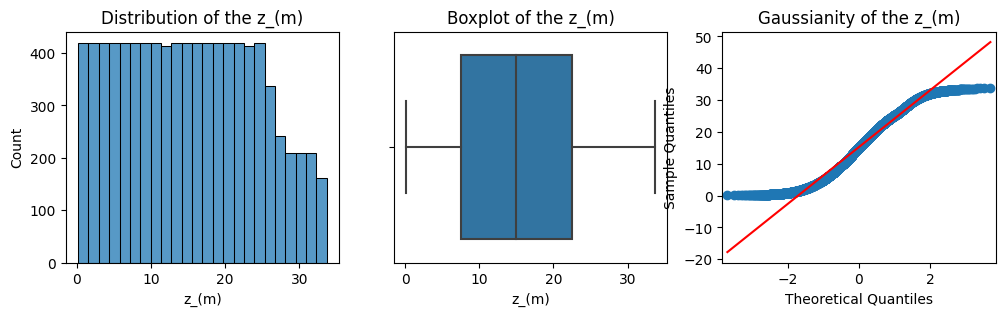

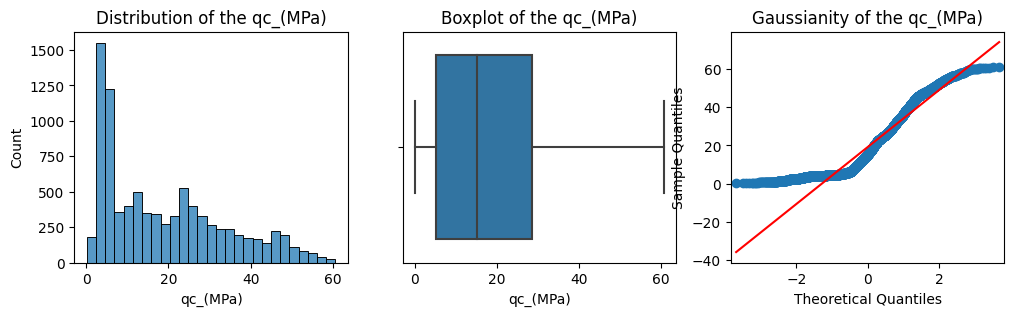

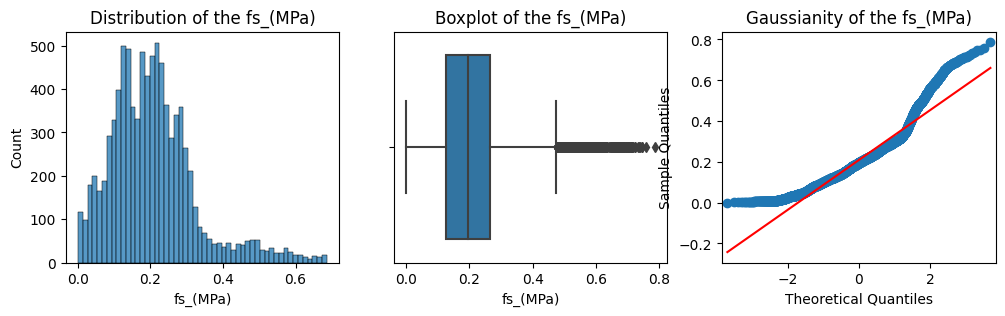

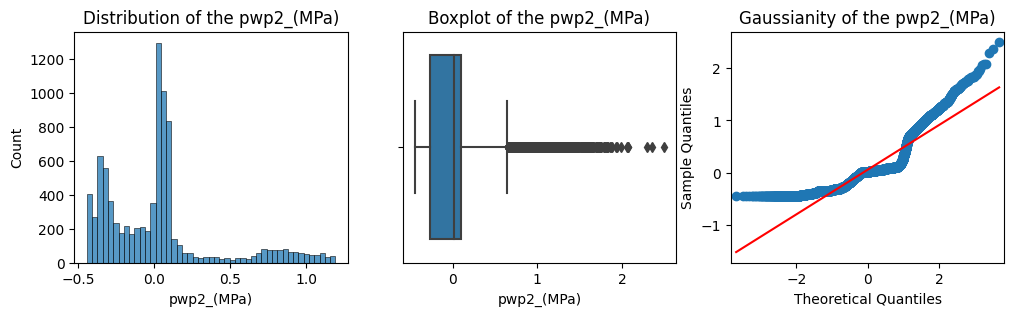

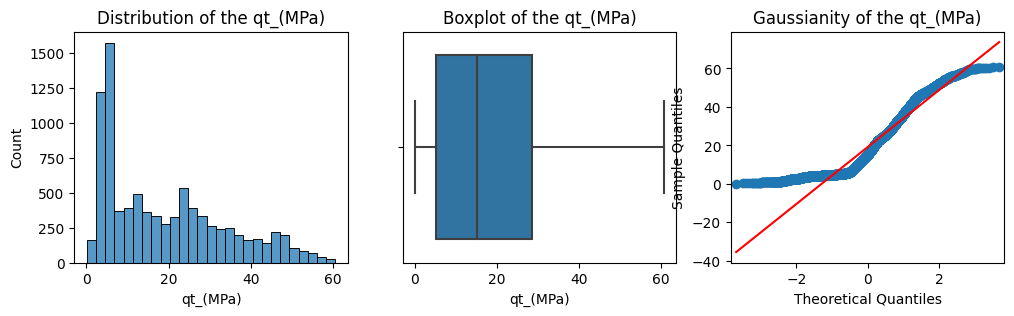

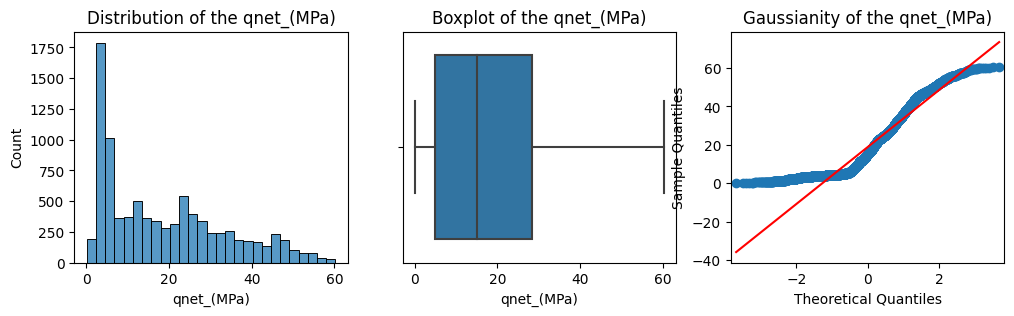

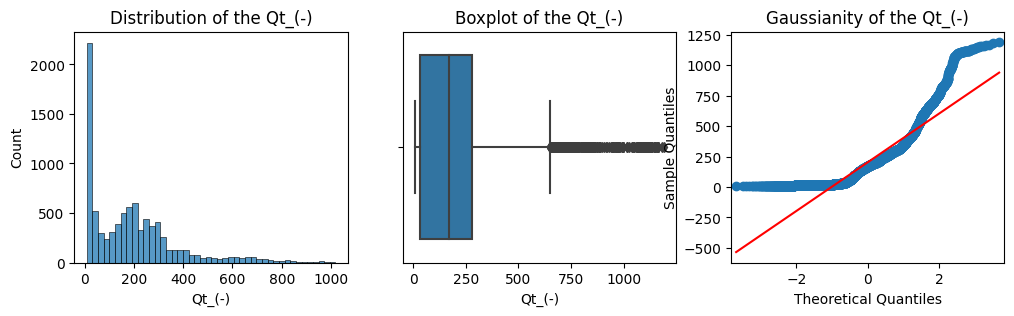

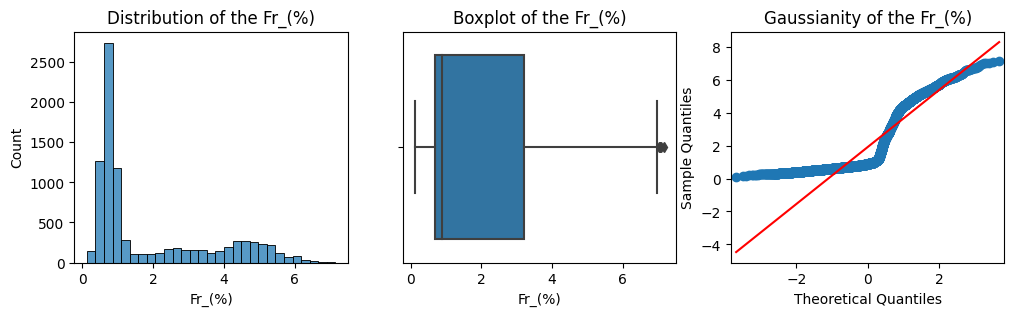

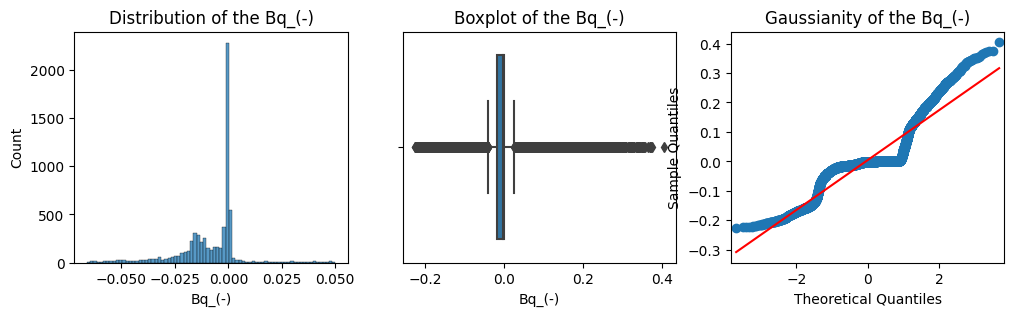

In [9]:
df_num = df.select_dtypes(exclude='object')
plot_distrib(df_num, df_num.columns)

# Target of the model

**The model target is defined as the soil classes obtained from the adjacent sampling boreholes to the CPT tests, the "real" classification.**

## Definition of the target

In [10]:
print(f'There are {df.Ground_model.nunique()} different classes and sub-classes to predict: {df.Ground_model.unique()}')

There are 12 different classes and sub-classes to predict: ['A' 'B' 'C1-c' 'C1-s' 'C1-cs' 'C2' 'C2-cs' 'D' 'E1' 'E1-c' 'E2' 'E3']


**The geotechnical description of the different classes are written below:**

In [11]:
dict_ground_model = {
    'A': 'Loose to very dense medium SAND',
    'B': 'Medium dense to very dense medium SAND, locally gravelly, locally bed(s) of clay',
    'C1': 'Alternation of medium dense to very dense silty fine SAND and very stiff CLAY',
    'C2': 'Very dense fine to medium SAND, locally beds with (many) glauconite',
    'D': 'Very stiff to hard fat CLAY',
    'E1': 'Medium dense to dense silty (or clayey) fine to medium SAND, locally with (many) glauconite',
    'E2': 'Medium dense very clayey fine to medium SAND, with thick to thin beds of CLAY, with (many) glauconite',
    'E3': 'Medium dense to very dense silty fine to medium SAND, locally with thin to thick beds with (many) glauconite' 
                    }

**🔶 The sub-classes use the suffix -cs, -s or -c to traduce the sandy (-s) or clayey (-c) nature of the sub-class.**

## Normalized CPT Soil Behavior Type chart, Qt - Fr

In [12]:
# Image properties
hue_order = np.sort(df.Ground_model.unique())
style_order = hue_order
palette = ['#C0C0C0', '#FFFF00', '#FF0000', '#800080', '#00FF00', '#FF7F50', 
           '#0000FF', '#FF00FF', '#000000', '#800000', '#808000', '#00FFFF']
source = '../img/robertson.png'

In [13]:
def plot_Rob(df_1, df_2, classes_to_plot_1, classes_to_plot_2, title_1, title_2):
    # Filtering the soil classes required
    mask_1 = eval(' | '.join([f"(df.Ground_model == '{Ground_model}')" for Ground_model in classes_to_plot_1]))
    mask_2 = eval(' | '.join([f"(df.Ground_model == '{Ground_model}')" for Ground_model in classes_to_plot_2]))
    
    # Seaborn scatter plot
    fig = plt.figure(figsize=(18,9))
    
    for mask, ind in zip((mask_1, mask_2), range(1, 3)):
        ax = fig.add_subplot(1, 2, ind)
    
        s = sns.scatterplot(
            data=eval(f'df_{ind}')[mask], y="Qt_(-)", x="Fr_(%)", 
            hue='Ground_model',
            style = 'Ground_model',
            palette=palette,   
            hue_order=hue_order,
            style_order=style_order,
            alpha=0.7,
            ax=ax)
    
        ax.loglog()
        ax.set_title(eval(f'title_{ind}'))
        ax.set_xlim(0.1, 10)
        ax.set_ylim(1, 1000)
        ax.set_zorder(2)
        ax.set_facecolor('none')

        # Update axis to add image as background
        ax_tw_x = ax.twinx()
        ax_tw_x.axis('off')
        ax2 = ax_tw_x.twiny()

        im = plt.imread(source)
        ax2.imshow(im, extent=[0.1, 10, 1, 1000], aspect='auto')
        ax2.axis('off')

    # Show plot
    plt.show()
    pass

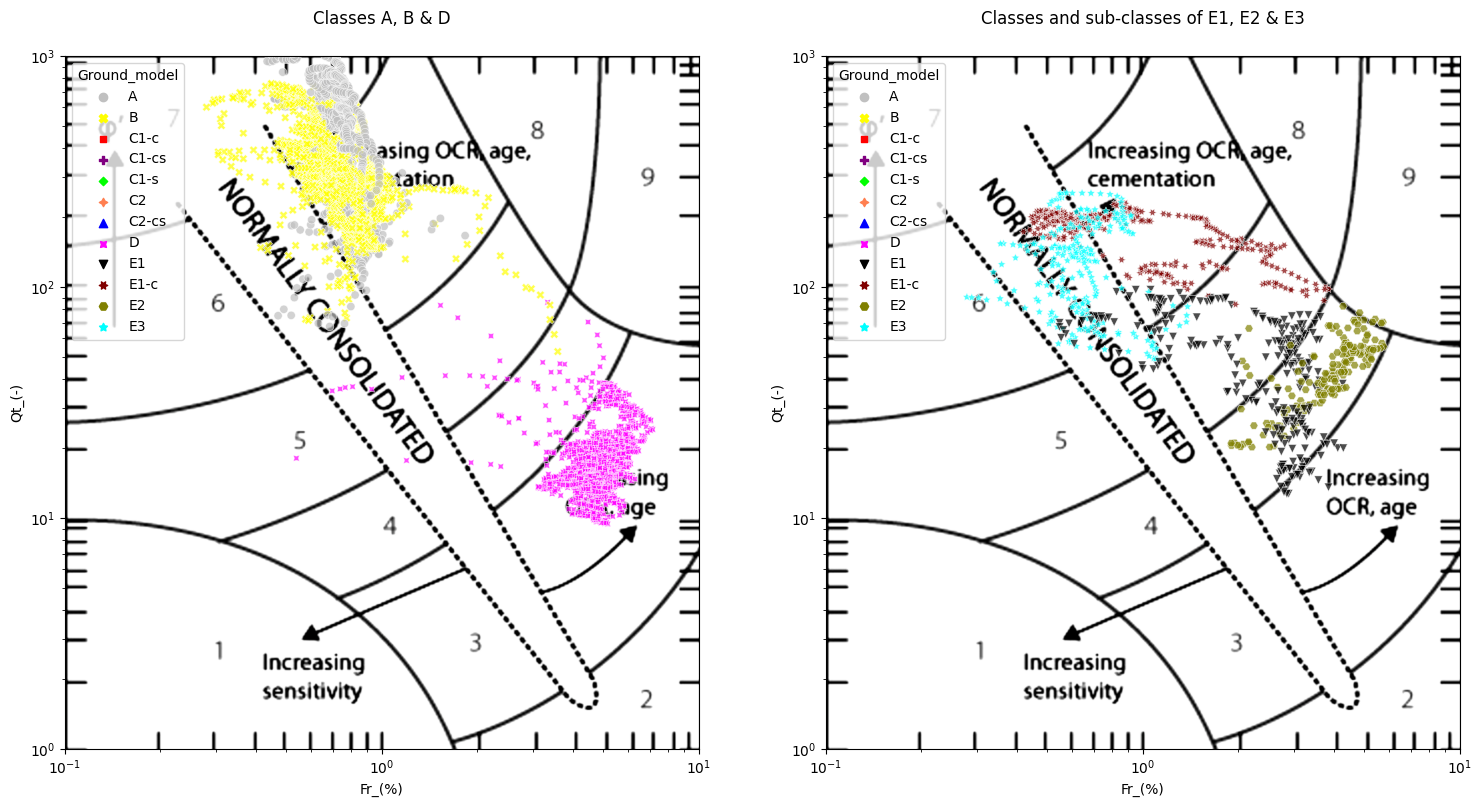

In [14]:
classes_to_plot_1 = ['A', 'B', 'D']
classes_to_plot_2 = ['E1', 'E1-c', 'E2', 'E3']
plot_Rob(df, df, classes_to_plot_1, classes_to_plot_2,
         "Classes A, B & D", "Classes and sub-classes of E1, E2 & E3")

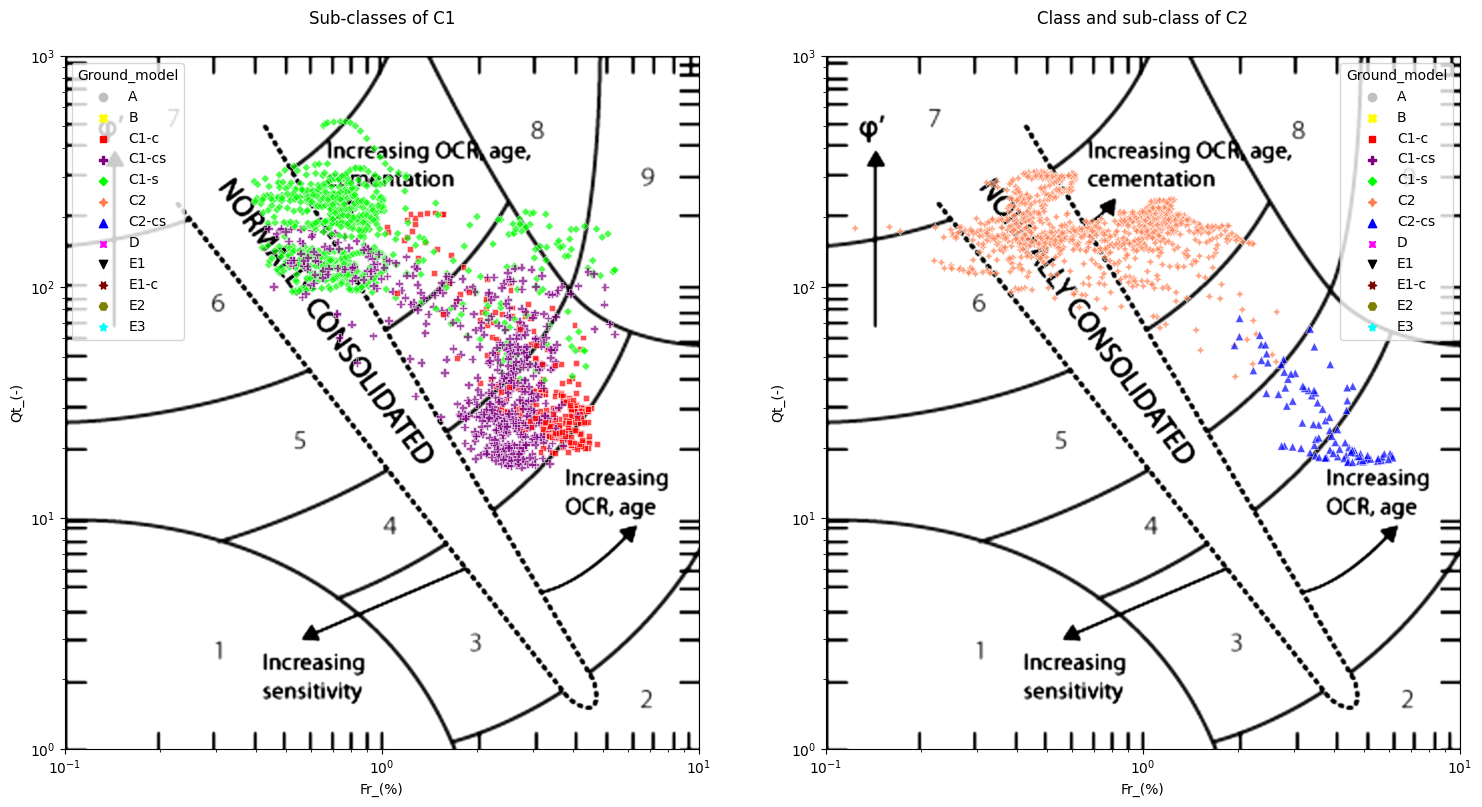

In [15]:
classes_to_plot_1 = ['C1-c', 'C1-cs', 'C1-s']
classes_to_plot_2 = ['C2', 'C2-cs']
plot_Rob(df, df, classes_to_plot_1, classes_to_plot_2,
        "Sub-classes of C1", "Class and sub-class of C2")

# Preprocessing

## Model preparation

**The train-test split (Holdout method) must be done in the first place (even before rebalancing the dataset) to avoid any data leakage!** \
**The train-test split is done such that the 4 first CPT constitute the train df and the 2 last CPT constitute the test df.** 

In [16]:
CPT_train = df.id.unique()[:-2]
CPT_test = df.id.unique()[-2:]

df_train = df.query('id.isin(@CPT_train)')
df_test = df.query('id.isin(@CPT_test)')

In [17]:
X_train, y_train = df_train.drop(columns=['id', 'Ground_model']), df_train.Ground_model
X_test, y_test = df_test.drop(columns=['id', 'Ground_model']), df_test.Ground_model

In [18]:
X_train.head()

,z_(m),qc_(MPa),fs_(MPa),pwp2_(MPa),qt_(MPa),qnet_(MPa),Qt_(-),Fr_(%),Bq_(-)
0,0.16,0.774,0.004908,0.0018,0.775,0.772,482.500000,0.718,0.000259
1,0.18,1.004,0.005917,0.0015,1.005,1.001,556.111111,0.660,-0.000300
2,0.20,1.185,0.006696,0.0019,1.186,1.182,591.000000,0.599,-0.000085
3,0.22,1.336,0.007394,0.0025,1.337,1.333,605.909091,0.568,0.000225
4,0.24,1.455,0.007550,0.0033,1.456,1.452,605.000000,0.531,0.000620


In [19]:
y_train.head()

0    A
1    A
2    A
3    A
4    A
Name: Ground_model, dtype: object

## Rebalancing classes

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

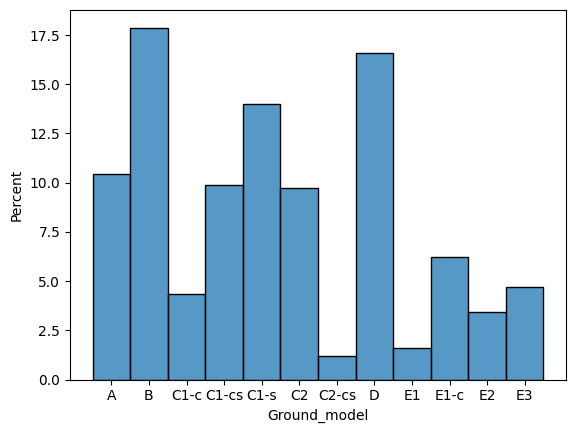

In [21]:
sns.histplot(data=y_train.sort_values(), stat='percent');

> **As you can notice of this histplot, the soil classes are not balanced. The classes C2-cs, C1-c, E1, E1-c and E2 are under-represented and represent less than 5% of the total number of samples in X_train. \
> This will conduct in overfitting the model on the most represented classes (A, B & D).**

We are goind to adopt two strategies to rebalance the classes :
- SMOTE over-sampling: It works by creating synthetic examples of the minority class by interpolating between existing minority class samples. 
- Random under-sampling: It works by randomly selecting a subset of samples from the majority class to match the size of the minority class.

🟨 This operation must be done on the train set only!

In [22]:
# Over-sampling the minority classes to reach 5% of the total count
classes_to_over_sample = ['C2-cs', 'C1-c', 'E1', 'E2']
ratios_over = [int(X_train.shape[0] * 0.05)] * len(classes_to_over_sample)

sampling_strategy_over = {key: value for key, value in zip(classes_to_over_sample, ratios_over)}

# Under-sampling the majority classes to reach 10% of the total count
classes_to_under_sample = ['B', 'D', 'C1-s']
ratios_under = [int(X_train.shape[0] * 0.1)] * len(classes_to_under_sample)

sampling_strategy_under = {key: value for key, value in zip(classes_to_under_sample, ratios_under)}

# Two strategies adopted
over = SMOTE(sampling_strategy=sampling_strategy_over, random_state=0)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=0)

# Pipeline
steps =  [('o', over), ('u', under)]
pipe_imblearn = Pipeline(steps=steps)

In [23]:
X_train_resampled, y_train_resampled = pipe_imblearn.fit_resample(X_train, y_train)

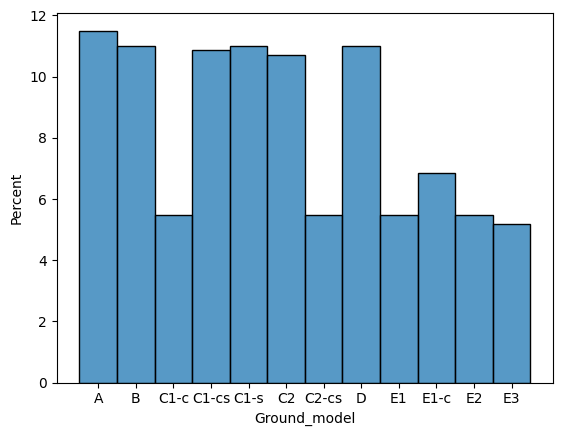

In [24]:
sns.histplot(data=y_train_resampled.sort_values(), stat='percent');

➡ All ground categories now represent between 5 to 11% of the total count.

🟨 Let's shuffle our train set again.

In [25]:
from sklearn.utils import shuffle

# Building the origin train set again and shuffling the rows
df_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
df_train_resampled = shuffle(df_train_resampled, random_state=0)

# Building X_train and y_train again
X_train_resampled = df_train_resampled.drop(columns=['Ground_model'])
y_train_resampled = df_train_resampled.Ground_model

## Preprocessing pipeline

### Scaling

In [26]:
df_train.columns

Index(['id', 'z_(m)', 'qc_(MPa)', 'fs_(MPa)', 'pwp2_(MPa)', 'qt_(MPa)',
       'qnet_(MPa)', 'Qt_(-)', 'Fr_(%)', 'Bq_(-)', 'Ground_model'],
      dtype='object')

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Model evaluation

## Testing several models

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
models_names = [
    "LogisticRegression", "RidgeClassifier", "KNN", "SVC", "RandomForest", "GradientBoosting"
]

models = [
    LogisticRegression(max_iter=1000), RidgeClassifier(), KNeighborsClassifier(n_neighbors=10), 
    SVC(kernel='rbf'), RandomForestClassifier(n_jobs=-1), GradientBoostingClassifier()
]

In [30]:
def compare_models(models_names, models, X_train, y_train, X_test, y_test):
    different_test_scores = []

    for model_name, model in zip(models_names, models):
        model.fit(X_train, y_train)
        different_test_scores.append(model.score(X_test, y_test))


    comparing_models = pd.DataFrame(list(zip(models_names, different_test_scores)),
                                    columns =['model_name', 'test_score'])

    return round(comparing_models.sort_values(by = "test_score", ascending = False), 2)


In [31]:
compare_models(models_names, models, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

,model_name,test_score
1,RidgeClassifier,0.73
0,LogisticRegression,0.64
4,RandomForest,0.58
5,GradientBoosting,0.56
2,KNN,0.51
3,SVC,0.51


**The best test score (accuracy) is obtained for the Ridge Classifier model.**

## Fine Tuning of RidgeClassifier

In [32]:
def get_score(X_train_scaled, y_train_resampled, alpha):
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train_scaled, y_train_resampled)
    score = model.score(X_test_scaled, y_test)
    return score

In [33]:
alpha_list = np.linspace(0, 50, 50)
scores = [get_score(X_train_scaled, y_train_resampled, alpha) for alpha in alpha_list]

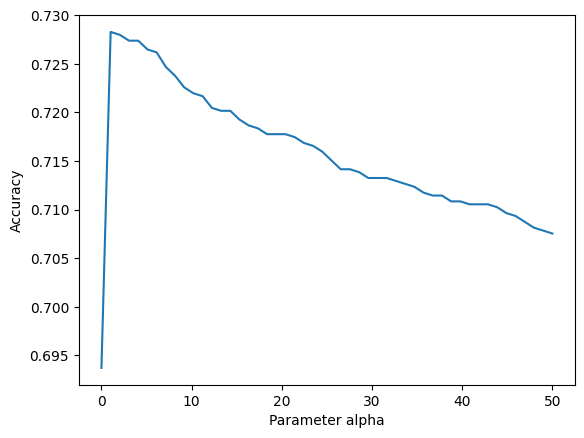

In [34]:
sns.lineplot(x=alpha_list, y=scores)
plt.xlabel('Parameter alpha')
plt.ylabel('Accuracy')
plt.show()

In [35]:
idx_score_max = scores.index(max(scores))
best_alpha = round(alpha_list[idx_score_max], 2)
best_alpha

1.02

**We notice that the default parameter alpha = 1 was the best choice.**

# Model Evaluation

In [36]:
# We choose the best model and store the predictions in y_pred
best_model = RidgeClassifier()
best_model.fit(X_train_scaled, y_train_resampled)
y_pred = pd.Series(best_model.predict(X_test_scaled)).rename('y_pred')

## Confusion Matrix

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

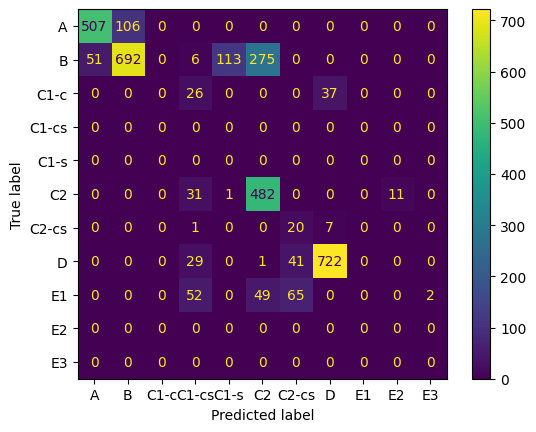

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

**Remarks** ✨ \
🔹 The model classified a large amount of B soils as C1-s and C2 (112 and 272 samples). It is not surprising that these classes were confused because their geotechnical description is quite similar (mostly medium dense sand, see §3.1). These 3 classes are classified as a soil type 6 in the Robertson chart (see §3.2). \
🔹 A and B classes were slightly confused. The same observation can be done on the Robertson classification because points overlap on the soil type 6 (see §3.2). \
🔹 The D class was clearly identified by the model which is a reassuring signal because its geotechnical nature is very specific (very  stiff clay, see §3.1 & §3.2). \
🔹 The categories C1-c and E1 were not predicted by the model. It is probably due to a lack of data for these 2 categories (although we performed SMOTE over-sampling on these categories).

## Comparing reality / predictions

In [39]:
df_results = pd.concat([df_test.reset_index(drop=True), y_pred], axis=1)

In [40]:
df_results.head()

,id,z_(m),qc_(MPa),fs_(MPa),pwp2_(MPa),qt_(MPa),qnet_(MPa),Qt_(-),Fr_(%),Bq_(-),Ground_model,y_pred
0,CPT_WFS1_8,0.16,0.269,0.004359,0.0023,0.270,0.267,166.875000,1.832,0.002622,A,A
1,CPT_WFS1_8,0.18,0.322,0.004450,0.0024,0.323,0.319,177.222222,1.436,0.001881,A,A
2,CPT_WFS1_8,0.20,0.379,0.005159,0.0024,0.380,0.376,188.000000,1.454,0.001064,A,A
3,CPT_WFS1_8,0.22,0.439,0.006171,0.0022,0.440,0.436,198.181818,1.531,0.000000,A,A
4,CPT_WFS1_8,0.24,0.752,0.007453,0.0017,0.753,0.748,311.666667,1.160,-0.000936,A,A


In [41]:
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

In [42]:
def compare_z_profile(df, id_borehole):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 10)
    
    # Real classificatio
    ax1.set_title(f'Real classification for {id_borehole}')
    ax1.invert_yaxis()
    sns.scatterplot(data=df.query('id == @id_borehole'), x=np.log(df["Qt_(-)"]), y='z_(m)', 
                    hue='Ground_model', hue_order=hue_order, palette=palette, ax=ax1, legend=False)
    ax1.set_xlabel('log(Qt)')
    
    # Model classification
    ax2.set_title(f'Machine Learning classification for {id_borehole}')
    ax2.invert_yaxis()
    sns.scatterplot(data=df.query('id == @id_borehole'), x=np.log(df["Qt_(-)"]), y='z_(m)', 
                 hue='y_pred', hue_order=hue_order, palette=palette, ax=ax2)
    ax2.set_xlabel('log(Qt)')
    
    ax2.legend(bbox_to_anchor=(1, 1))
    plt.show()
    return fig

### CPT_WFS1_8

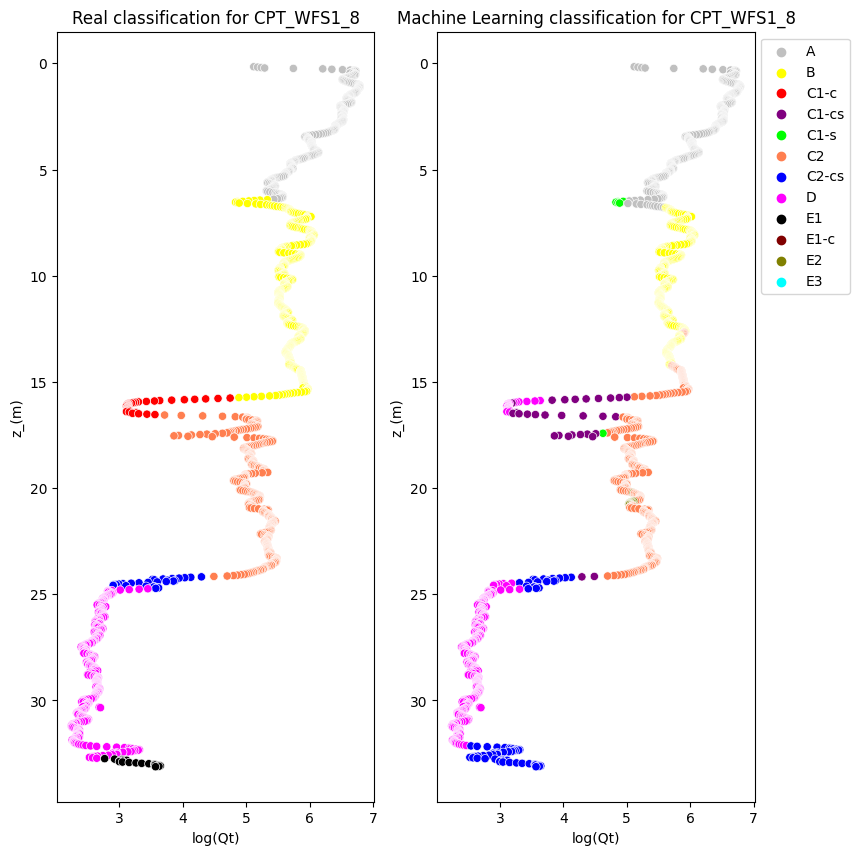

In [43]:
fig = compare_z_profile(df_results, "CPT_WFS1_8")

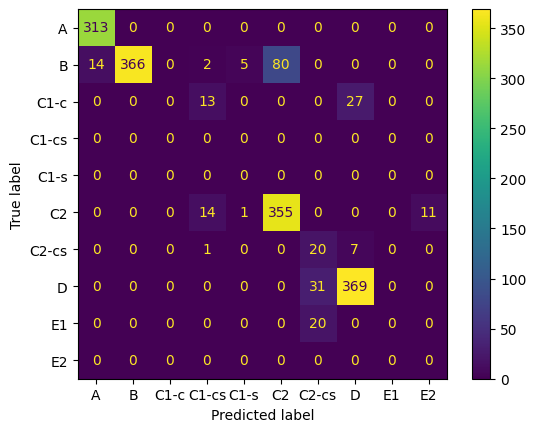

In [44]:
y_test_temp = df_results.query('id == "CPT_WFS1_8"').Ground_model
y_pred_temp = df_results.query('id == "CPT_WFS1_8"').y_pred

ConfusionMatrixDisplay.from_predictions(y_test_temp, y_pred_temp);

### CPT_WFS1_9

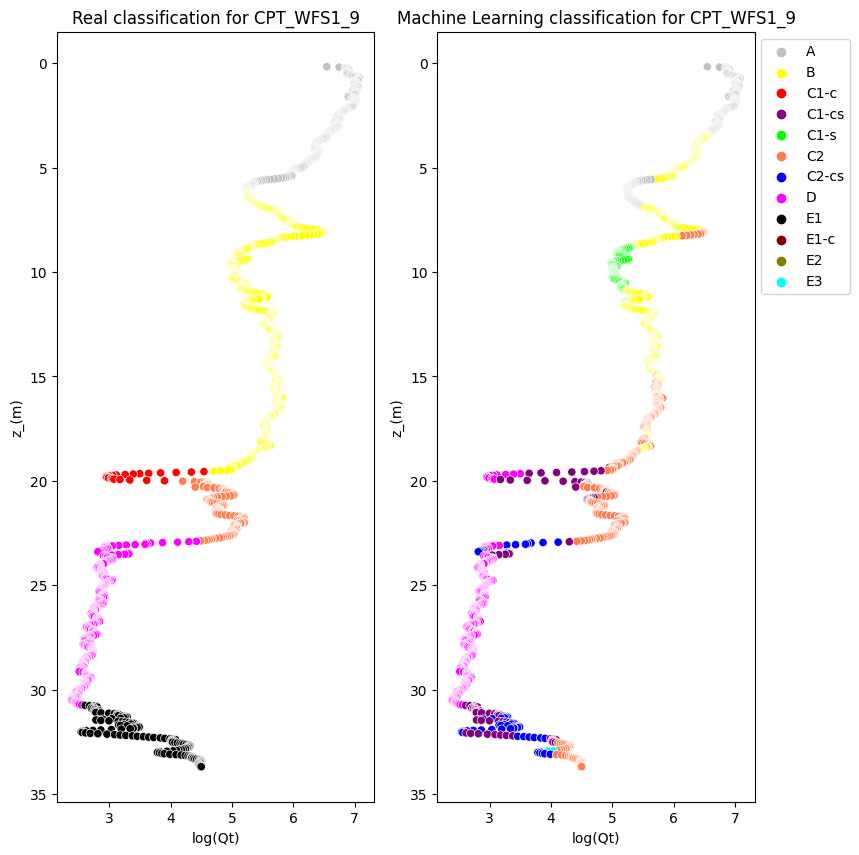

In [45]:
fig = compare_z_profile(df_results, "CPT_WFS1_9")

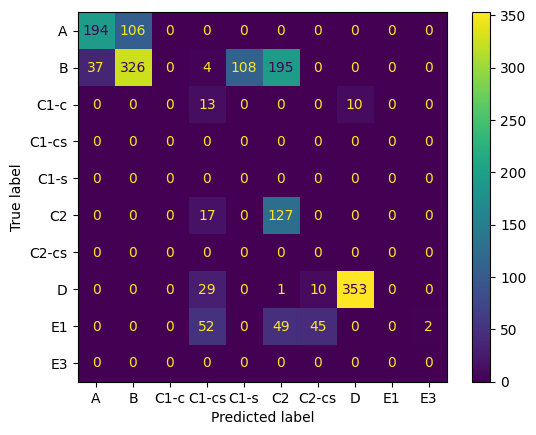

In [46]:
y_test_temp = df_results.query('id == "CPT_WFS1_9"').Ground_model
y_pred_temp = df_results.query('id == "CPT_WFS1_9"').y_pred

ConfusionMatrixDisplay.from_predictions(y_test_temp, y_pred_temp);

# Conclusion

**Here are a few observations and insights that can be inferred from this exercise ✨**\
It appears from the model evaluation that the global patterns were correctly captured by the Machine Learning model.\
It remains a few errors as you can see in the Confusion Matrix. But it may be recalled that this model was trained on a relatively small amount of data (only 4 CPTs in the train set).\
Moreover the real classification known thanks to the sampling boreholes was quite complex (12 different categories, see 3.1). Another approach would have been to simplify that classification, e.g by merging the sub-classes of a same class (merging C1-c, C1-s and C1-cs in a C1 class for example). Results could be improved by decreasing the number of classes to predict.

If you have any remarks, comments or ideas please let me know on LinkedIn! 📩\
https://www.linkedin.com/in/simon-hosny/?locale=en_US